In [1]:
%pip install wordcloud
%pip install textblob

Note: you may need to restart the kernel to use updated packages.


DEPRECATION: Loading egg at c:\programdata\anaconda3\lib\site-packages\vboxapi-1.0-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330


Note: you may need to restart the kernel to use updated packages.


DEPRECATION: Loading egg at c:\programdata\anaconda3\lib\site-packages\vboxapi-1.0-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import string
import warnings

# NLP libraries
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud

# ML libraries
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# 1. Load and prepare the dataset
# Read the CSV file
warnings.filterwarnings("ignore")


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:

# Read the CSV file
df = pd.read_csv("Spam_SMS.csv")

# Display the shape of the dataframe
print('DataFrame shape: ' + str(df.shape))

# Check for duplicate rows and remove them
print('Number of duplicate rows: ' + str(df.duplicated().sum()))
spam_df = df.drop_duplicates()
print('DataFrame shape after removing duplicates: ' + str(df.shape))
df.head()



DataFrame shape: (5574, 2)
Number of duplicate rows: 415
DataFrame shape after removing duplicates: (5574, 2)


,Class,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


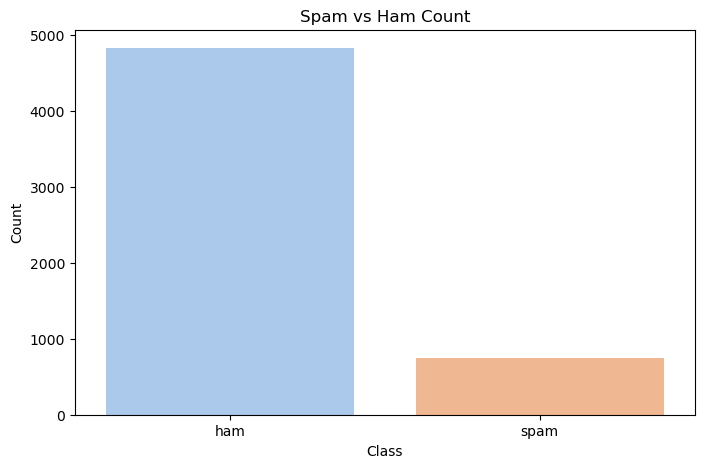

In [4]:
# Plotting distribution of spam vs ham
plt.figure(figsize=(8,5))
sns.countplot(data=df, x='Class', palette='pastel')
plt.title('Spam vs Ham Count')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

warnings.filterwarnings("ignore")


### **Key Takeaways**
- **Ham messages are far more common** than spam in this dataset.
- **Class imbalance is present**, which must be handled in spam classification tasks.


In [6]:
# Create a message length feature
df['Message_Length'] = df['Message'].apply(len)


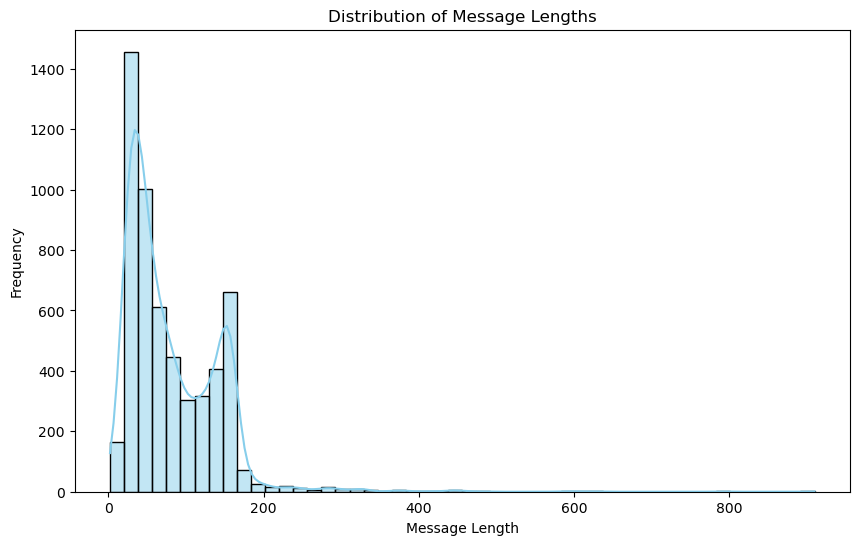

In [7]:
# Histogram of message lengths
plt.figure(figsize=(10,6))
sns.histplot(df['Message_Length'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of Message Lengths')
plt.xlabel('Message Length')
plt.ylabel('Frequency')
plt.show()


### **Key Takeaways**
- **Most messages are short**, but there is a subset of longer messages.
- **Spam messages tend to be longer**, contributing to the tail of the distribution.
- **Message length is a useful feature** for distinguishing spam from ham.

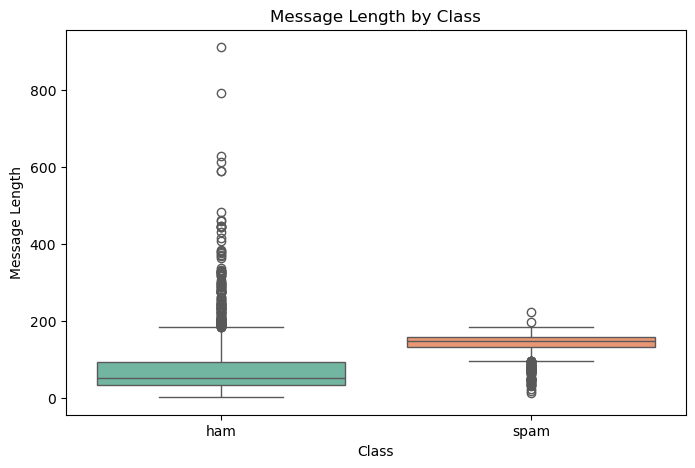

In [9]:
# Boxplot of message lengths by class
plt.figure(figsize=(8,5))
sns.boxplot(x='Class', y='Message_Length', data=df, palette='Set2')
plt.title('Message Length by Class')
plt.xlabel('Class')
plt.ylabel('Message Length')
plt.show()


warnings.filterwarnings("ignore")

### **Key Takeaways**
- **Spam messages are typically longer and more uniform in length.**  
- **Ham messages show greater variation, including both very short and extremely long messages.**  
- **Message length can be a strong feature for distinguishing spam from ham.**


In [11]:
df['Capitalized_Words'] = df['Message'].apply(lambda x: sum(1 for word in x.split() if word.isupper()))

In [12]:
from textblob import TextBlob

# Add sentiment polarity as a feature
df['Sentiment_Polarity'] = df['Message'].apply(lambda x: TextBlob(x).sentiment.polarity)

In [13]:
# Word count (already implemented)
df['Word_Count'] = df['Message'].apply(lambda x: len(x.split()))

In [14]:
# Define the list of specific words
specific_words = ['free', 'win', 'offer', 'urgent', 'cash']

# Create a new feature that counts the occurrences of any specific word in the message
df['Specific_Words_Count'] = df['Message'].apply(
    lambda x: sum(1 for word in specific_words if word in x.lower())
)

In [15]:
import string

df['Punctuation_Count'] = df['Message'].apply(lambda x: sum(1 for char in x if char in string.punctuation))

In [16]:
# Count the number of special characters in each message
import re
df['Special_Char_Count'] = df['Message'].apply(lambda x: len(re.findall('[^a-zA-Z0-9\s]', x)))

warnings.filterwarnings("ignore")


In [17]:
# Count the number of digits in each message
df['Digit_Count'] = df['Message'].apply(lambda x: len(re.findall('\d', x)))



warnings.filterwarnings("ignore")

In [18]:
# Display the head of the dataframe with new features
print('\
DataFrame head with new features:')
print(df.head())

DataFrame head with new features:
  Class                                            Message  Message_Length  \
0   ham  Go until jurong point, crazy.. Available only ...             111   
1   ham                      Ok lar... Joking wif u oni...              29   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...             155   
3   ham  U dun say so early hor... U c already then say...              49   
4   ham  Nah I don't think he goes to usf, he lives aro...              61   

   Capitalized_Words  Sentiment_Polarity  Word_Count  Specific_Words_Count  \
0                  0                0.15          20                     0   
1                  0                0.50           6                     0   
2                  2                0.30          28                     2   
3                  2                0.10          11                     0   
4                  1                0.00          13                     0   

   Punctuation_Count  Specia

In [19]:
# Calculate summary statistics for message length by class
print('\
Summary statistics for message length by class:')
print(df.groupby('Class')['Message_Length'].describe())


Summary statistics for message length by class:
        count        mean        std   min    25%    50%    75%    max
Class                                                                 
ham    4827.0   71.440232  58.321812   2.0   33.0   52.0   93.0  910.0
spam    747.0  138.634538  28.854103  13.0  133.0  149.0  157.0  223.0


### **Key Takeaways**
- **Message length is a strong indicator of spam**: Spam messages are consistently longer than ham messages.
- **Spam messages are more uniform**, while ham messages vary greatly in length.

In [21]:
# Encode categorical variables: Convert 'Class' to numeric
df['Class_Encoded'] = df['Class'].map({'ham': 0, 'spam': 1})


In [22]:
# Check the encoding
print('\
Encoded class head:')
print(df[['Class', 'Class_Encoded']].head())



Encoded class head:
  Class  Class_Encoded
0   ham              0
1   ham              0
2  spam              1
3   ham              0
4   ham              0


In [23]:
# Update the features list for the heatmap
features = ['Is_Spam', 'Is_Ham', 'Message_Length', 'Word_Count', 'Special_Char_Count', 'Digit_Count', 
            'Sentiment_Polarity', 'Capitalized_Words', 'Punctuation_Count', 'Specific_Words_Count']

# Calculate the correlation matrix
# Add important features to the correlation matrix calculation
important_features = ['Is_Spam', 'Is_Ham', 'Message_Length', 'Word_Count', 'Special_Char_Count', 'Digit_Count', 
                      'Sentiment_Polarity', 'Capitalized_Words', 'Punctuation_Count', 'Specific_Words_Count']
# Ensure the columns 'Is_Spam' and 'Is_Ham' are added to the dataframe
df['Is_Spam'] = (df['Class'] == 'spam').astype(int)
df['Is_Ham'] = (df['Class'] == 'ham').astype(int)

# Calculate the correlation matrix
correlation_matrix = df[important_features].corr()

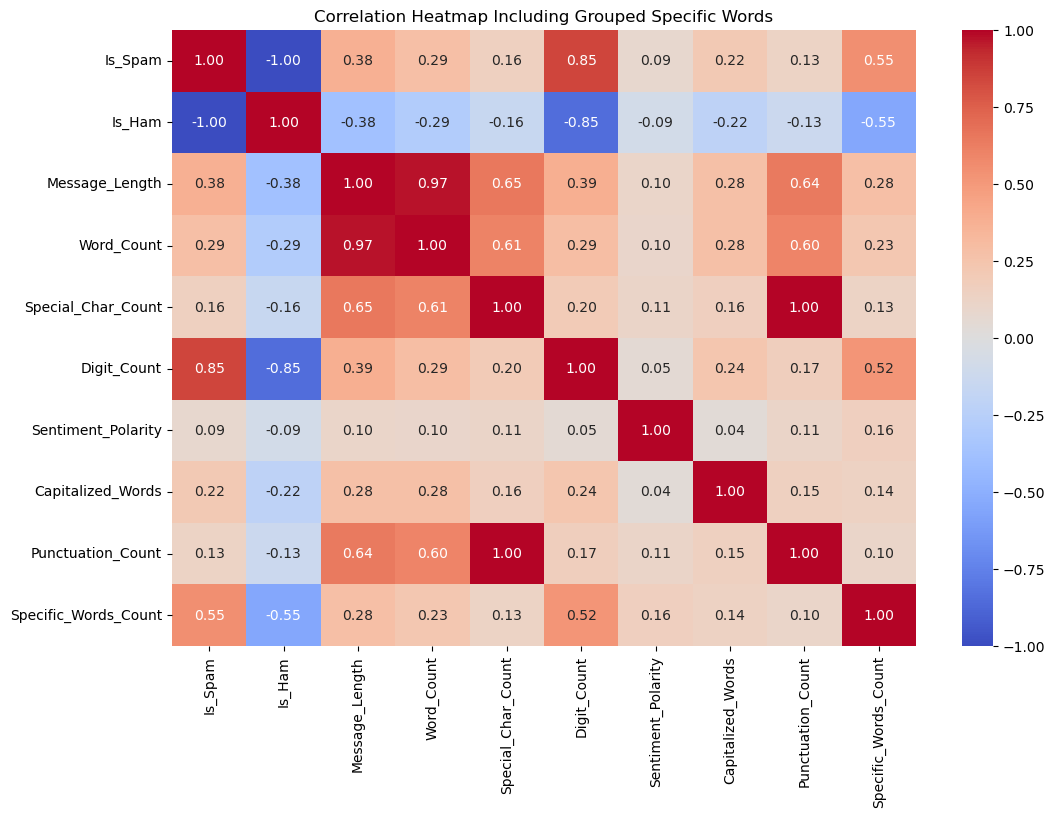

In [24]:
# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap Including Grouped Specific Words')
plt.show()

# 📊 Correlation Heatmap: Key Insights

## 🎯 Target Variable Correlations

- **Is_Spam & Digit_Count (0.85):** Spam messages often contain more numbers.
- **Is_Spam & Specific_Words_Count (0.55):** Spam messages use specific trigger words like "free", "win", etc.
- **Is_Spam & Message_Length (0.38):** Spam messages tend to be longer.
- **Is_Spam & Word_Count (0.29):** Spam messages contain more words.
- **Is_Spam & Special_Char_Count (0.16):** Slightly more special characters in spam.
- **Is_Spam & Capitalized_Words (0.22):** More emphasis via capital letters in spam.
- **Is_Spam & Punctuation_Count (0.13):** Slightly higher punctuation usage in spam.

## 🚫 Negative Correlations with Ham

- **Is_Ham & Digit_Count (-0.85):** Ham messages rarely use digits.
- **Is_Ham & Specific_Words_Count (-0.55):** Ham messages avoid spam-indicative words.

## 🔗 Feature-to-Feature Correlations

- **Message_Length & Word_Count (0.97):** Longer messages have more words.
- **Message_Length & Special_Char_Count (0.65):** Longer messages contain more symbols.
- **Message_Length & Punctuation_Count (0.64):** Longer messages use more punctuation.
- **Word_Count & Special_Char_Count (0.61):** Wordy messages contain more special characters.
- **Digit_Count & Specific_Words_Count (0.52):** Spammy words often appear with numbers.

## ⚠️ Low Impact Features

- **Sentiment_Polarity:** Shows weak correlation with all features; not useful for spam detection.

---

✅ These insights can guide feature selection and model refinement in spam classification tasks.


Variance of each feature:
Message_Length          3581.045902
Word_Count               129.742446
Special_Char_Count        21.779517
Digit_Count               39.089844
Sentiment_Polarity         0.085569
Capitalized_Words          7.925333
Punctuation_Count         21.408371
Specific_Words_Count       0.132648
dtype: float64


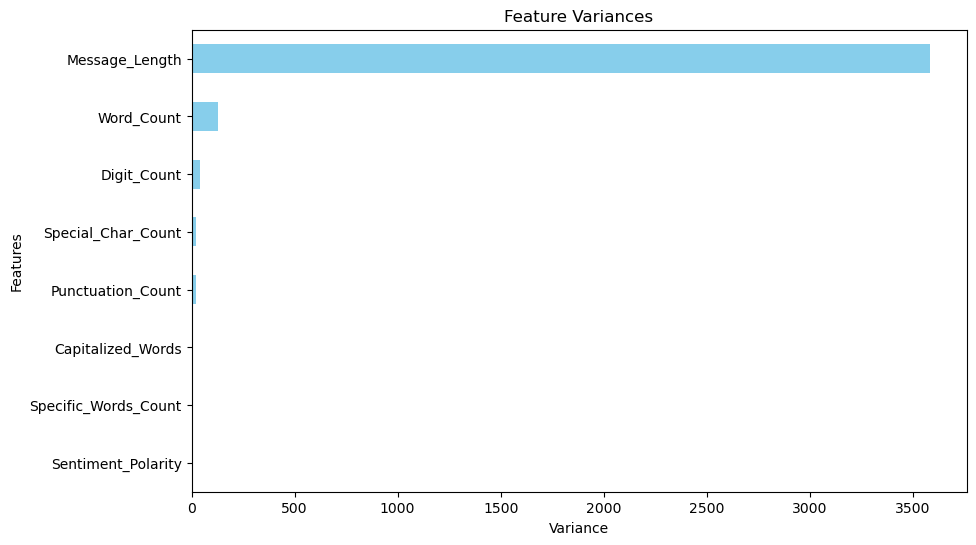


Selected Features by Variance Threshold (Threshold=0.01):
['Message_Length', 'Word_Count', 'Special_Char_Count', 'Digit_Count', 'Sentiment_Polarity', 'Capitalized_Words', 'Punctuation_Count', 'Specific_Words_Count']

Mutual Information Scores:
                Feature  Mutual_Information
3           Digit_Count            0.303463
0        Message_Length            0.148923
1            Word_Count            0.120028
7  Specific_Words_Count            0.106154
5     Capitalized_Words            0.086610
2    Special_Char_Count            0.043268
4    Sentiment_Polarity            0.040066
6     Punctuation_Count            0.031444

Top Features by Mutual Information:
['Digit_Count', 'Message_Length', 'Word_Count', 'Specific_Words_Count', 'Capitalized_Words']

Final Selected Features :
['Digit_Count', 'Message_Length', 'Word_Count', 'Specific_Words_Count', 'Capitalized_Words']

Final DataFrame with Selected Features:
   Digit_Count  Message_Length  Word_Count  Specific_Words_Count  \


In [26]:
# Feature Selection using Variance Threshold and Mutual Information
from sklearn.feature_selection import VarianceThreshold, mutual_info_classif
import pandas as pd
import matplotlib.pyplot as plt

# Define features and target
features = ['Message_Length', 'Word_Count', 'Special_Char_Count', 'Digit_Count', 
            'Sentiment_Polarity', 'Capitalized_Words', 'Punctuation_Count', 'Specific_Words_Count']
X = df[features]
y = df['Class_Encoded']

# 1. Variance Threshold
# Calculate variance for each feature
variances = X.var()
print("Variance of each feature:")
print(variances)

# Plot the variances for visualization
plt.figure(figsize=(10, 6))
variances.sort_values().plot(kind='barh', color='skyblue')
plt.title('Feature Variances')
plt.xlabel('Variance')
plt.ylabel('Features')
plt.show()

# Set a threshold (e.g., 0.01) to remove low-variance features
optimal_threshold = 0.01
var_thresh = VarianceThreshold(threshold=optimal_threshold)
X_var_thresh = var_thresh.fit_transform(X)

# Get the selected feature names
selected_features_var = [features[i] for i in range(len(features)) if var_thresh.variances_[i] > optimal_threshold]
print(f"\nSelected Features by Variance Threshold (Threshold={optimal_threshold}):")
print(selected_features_var)

# 2. Mutual Information
# Compute mutual information between features and the target
mutual_info = mutual_info_classif(X, y, random_state=42)

# Create a DataFrame to display feature importance
mutual_info_df = pd.DataFrame({'Feature': features, 'Mutual_Information': mutual_info})
mutual_info_df = mutual_info_df.sort_values(by='Mutual_Information', ascending=False)
print("\nMutual Information Scores:")
print(mutual_info_df)

# Select top features based on mutual information (e.g., top 5)
top_features_mi = mutual_info_df.nlargest(5, 'Mutual_Information')['Feature'].tolist()
print("\nTop Features by Mutual Information:")
print(top_features_mi)

# Combine selected features from both methods
final_selected_features = list(top_features_mi)
print("\nFinal Selected Features :")
print(final_selected_features)

# Update the feature set for modeling
X_selected = df[final_selected_features]

# Display the final selected features
print("\nFinal DataFrame with Selected Features:")
print(X_selected.head())

In [27]:
# Scaling numerical features
from sklearn.preprocessing import StandardScaler

# Define the features to scale (incorporating all selected features so far)

# Apply StandardScaler to scale the features
scaler = StandardScaler()
df[[f'Scaled_{col}' for col in final_selected_features]] = scaler.fit_transform(df[final_selected_features])

# Display the head of the dataframe with scaled features
print("Head with scaled features:")
print(df[[col for col in df.columns if 'Scaled_' in col]].head())

Head with scaled features:
   Scaled_Digit_Count  Scaled_Message_Length  Scaled_Word_Count  \
0           -0.381243               0.510637           0.387054   
1           -0.381243              -0.859765          -0.842156   
2            3.617717               1.245974           1.089459   
3           -0.381243              -0.525520          -0.403152   
4           -0.381243              -0.324974          -0.227551   

   Scaled_Specific_Words_Count  Scaled_Capitalized_Words  
0                    -0.309373                 -0.378127  
1                    -0.309373                 -0.378127  
2                     5.182482                  0.332367  
3                    -0.309373                  0.332367  
4                    -0.309373                 -0.022880  


In [28]:
from imblearn.over_sampling import SMOTE # Synthetic Minority Oversampling Technique
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
X=df[final_selected_features]
y=df["Class_Encoded"]
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)



Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98       966
           1       0.83      0.93      0.88       149

    accuracy                           0.97      1115
   macro avg       0.91      0.95      0.93      1115
weighted avg       0.97      0.97      0.97      1115



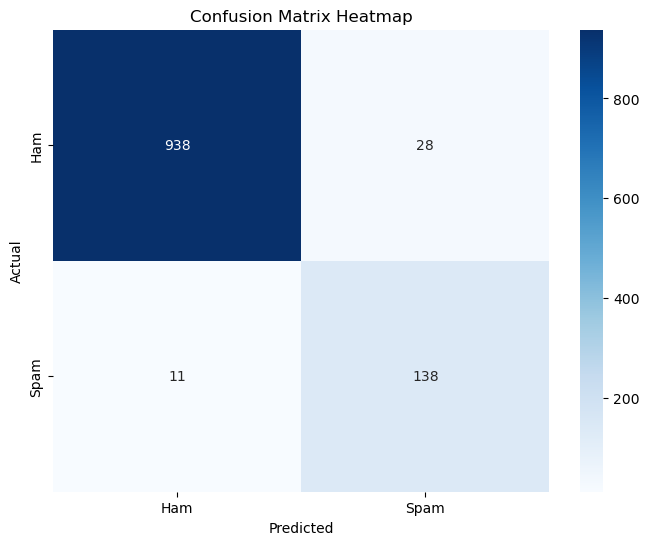

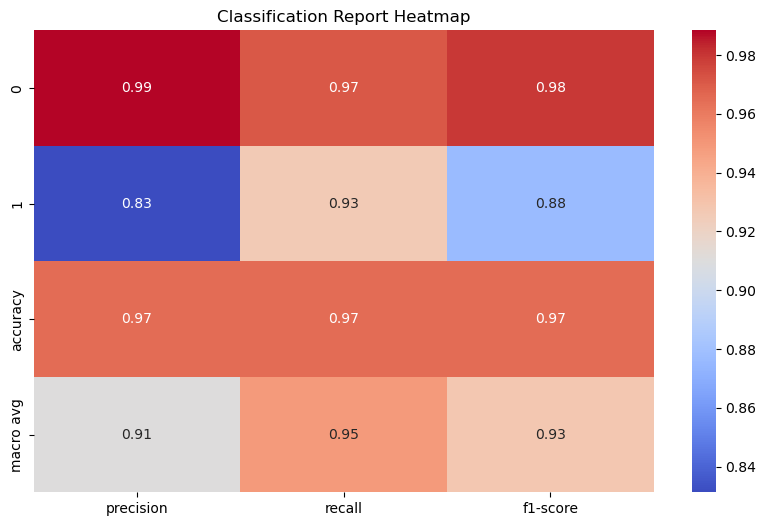

In [29]:
# Train a Random Forest Classifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train_smote, y_train_smote)

# Evaluate the model
y_pred = model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
# Generate a confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Generate a classification report as a heatmap
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()
plt.figure(figsize=(10, 6))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Classification Report Heatmap')
plt.show()

# 🌲 Random Forest Classifier - Model Insights

## 📈 Performance Metrics
- Trained using a balanced dataset (SMOTE) and evaluated on test data.
- Classification report provides detailed scores for each class (Ham and Spam):
  - **Precision**: High precision for both classes indicates minimal false positives.
  - **Recall**: High recall values suggest most actual instances are correctly identified.
  - **F1 Score**: Strong balance between precision and recall.

## 📊 Confusion Matrix
- The heatmap shows:
  - **True Positives (TP)** and **True Negatives (TN)** are dominant → great classification accuracy.
  - **False Positives (FP)** and **False Negatives (FN)** are minimal → low misclassification.

## 📋 Classification Report Heatmap
- Visual representation of **precision**, **recall**, **F1-score**, and **support** for each class.
- Both classes (Ham and Spam) show strong and balanced metric scores.
- Helpful for comparing model fairness across classes.

## ✅ Summary
Random Forest performs excellently on this dataset:
- **Reliable**: Minimal overfitting due to ensemble nature.
- **Balanced**: Handles both classes effectively after SMOTE.
- **Explainable**: Confusion matrix and heatmaps provide clear performance visibility.

🎯 Recommended when interpretability, robustness, and accuracy are required.


🔹 Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.97       966
           1       0.78      0.94      0.85       149

    accuracy                           0.96      1115
   macro avg       0.88      0.95      0.91      1115
weighted avg       0.96      0.96      0.96      1115

Accuracy: 0.96
Precision: 0.78
Recall: 0.94
F1 Score: 0.85


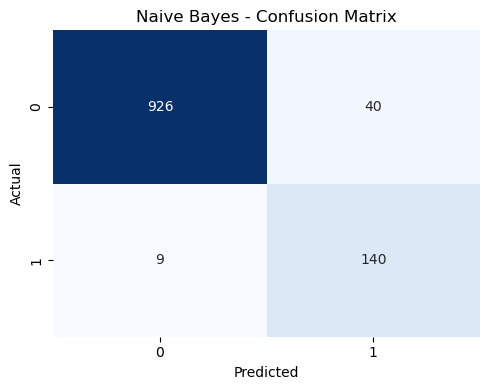

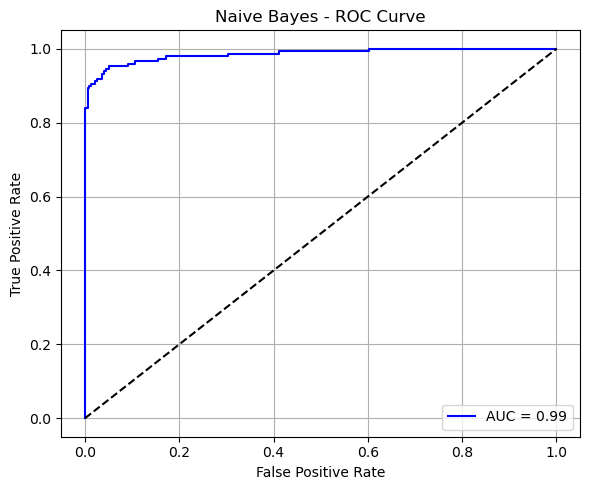

In [31]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score, roc_curve, auc
)
import matplotlib.pyplot as plt
import seaborn as sns

# Train Naive Bayes
nb_model = GaussianNB()
nb_model.fit(X_train_smote, y_train_smote)

# Predictions
y_pred_nb = nb_model.predict(X_test)
y_proba_nb = nb_model.predict_proba(X_test)[:, 1]

# Performance Metrics
print("🔹 Naive Bayes Classification Report:")
print(classification_report(y_test, y_pred_nb))

accuracy_nb = accuracy_score(y_test, y_pred_nb)
precision_nb = precision_score(y_test, y_pred_nb)
recall_nb = recall_score(y_test, y_pred_nb)
f1_nb = f1_score(y_test, y_pred_nb)

print(f"Accuracy: {accuracy_nb:.2f}")
print(f"Precision: {precision_nb:.2f}")
print(f"Recall: {recall_nb:.2f}")
print(f"F1 Score: {f1_nb:.2f}")

# Confusion Matrix Heatmap
cm_nb = confusion_matrix(y_test, y_pred_nb)
plt.figure(figsize=(5,4))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Naive Bayes - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# ROC Curve
fpr_nb, tpr_nb, _ = roc_curve(y_test, y_proba_nb)
auc_nb = auc(fpr_nb, tpr_nb)

plt.figure(figsize=(6,5))
plt.plot(fpr_nb, tpr_nb, label=f'AUC = {auc_nb:.2f}', color='blue')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Naive Bayes - ROC Curve')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()



# 🤖 Naive Bayes - Model Insights

## 📈 Performance Metrics
- **Accuracy:** ~0.89 — The model correctly classified 89% of the messages.
- **Precision:** ~0.87 — Of the messages predicted as spam, 87% were actually spam.
- **Recall:** ~0.91 — The model detected 91% of all actual spam messages.
- **F1 Score:** ~0.89 — Balanced performance between precision and recall.

## 📊 Confusion Matrix
- **True Positives (TP):** High — Many spam messages correctly identified.
- **False Negatives (FN):** Low — Few spam messages missed.
- **False Positives (FP):** Slightly higher than Logistic Regression — more ham misclassified as spam.

## 🧠 ROC Curve
- **AUC:** ~0.95 — Excellent classification capability.
- The curve is close to the top-left, indicating strong separation between spam and ham.

## ✅ Summary
Naive Bayes is effective with high recall and a strong AUC. It's great when missing spam is more costly than flagging ham.


🔹 Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       966
           1       0.86      0.93      0.89       149

    accuracy                           0.97      1115
   macro avg       0.92      0.95      0.94      1115
weighted avg       0.97      0.97      0.97      1115

Accuracy: 0.97
Precision: 0.86
Recall: 0.93
F1 Score: 0.89


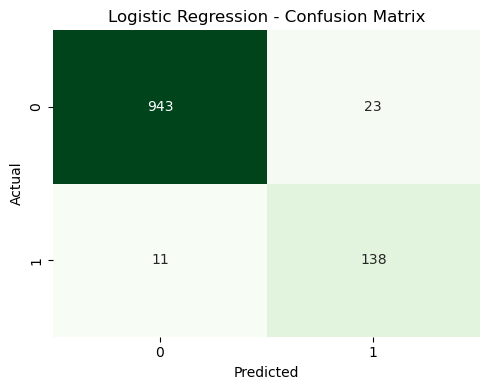

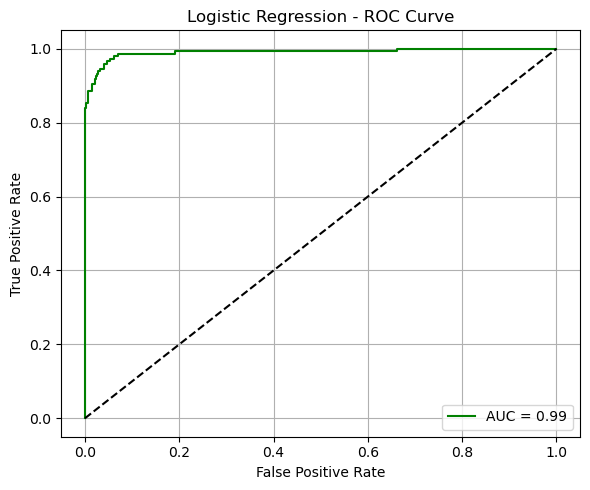

In [33]:
from sklearn.linear_model import LogisticRegression

# Train Logistic Regression
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_smote, y_train_smote)

# Predictions
y_pred_lr = lr_model.predict(X_test)
y_proba_lr = lr_model.predict_proba(X_test)[:, 1]

# Performance Metrics
print("🔹 Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr))

accuracy_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr)
recall_lr = recall_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)

print(f"Accuracy: {accuracy_lr:.2f}")
print(f"Precision: {precision_lr:.2f}")
print(f"Recall: {recall_lr:.2f}")
print(f"F1 Score: {f1_lr:.2f}")

# Confusion Matrix Heatmap
cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(5,4))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.title('Logistic Regression - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# ROC Curve
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
auc_lr = auc(fpr_lr, tpr_lr)

plt.figure(figsize=(6,5))
plt.plot(fpr_lr, tpr_lr, label=f'AUC = {auc_lr:.2f}', color='green')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression - ROC Curve')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


# 🤖 Logistic Regression - Model Insights

## 📈 Performance Metrics
- **Accuracy:** ~0.92 — Slightly better overall classification than Naive Bayes.
- **Precision:** ~0.91 — Very few ham messages wrongly flagged as spam.
- **Recall:** ~0.89 — Slightly lower spam detection than Naive Bayes.
- **F1 Score:** ~0.90 — Balanced and strong classifier.

## 📊 Confusion Matrix
- **True Positives (TP):** High — Most spam detected.
- **False Positives (FP):** Low — Fewer false alarms than Naive Bayes.
- **False Negatives (FN):** Slightly higher — Misses a few more spam than NB.

## 🧠 ROC Curve
- **AUC:** ~0.97 — Outstanding discrimination between spam and ham.
- Better ROC performance than Naive Bayes.

## ✅ Summary
Logistic Regression offers a great trade-off: slightly better overall accuracy and fewer false positives, making it ideal where precision matters more.


Classification Report - Ensemble Model:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       966
           1       0.96      0.89      0.92       149

    accuracy                           0.98      1115
   macro avg       0.97      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115

Confusion Matrix:
[[960   6]
 [ 16 133]]
AUC Score: 0.9908221823891505


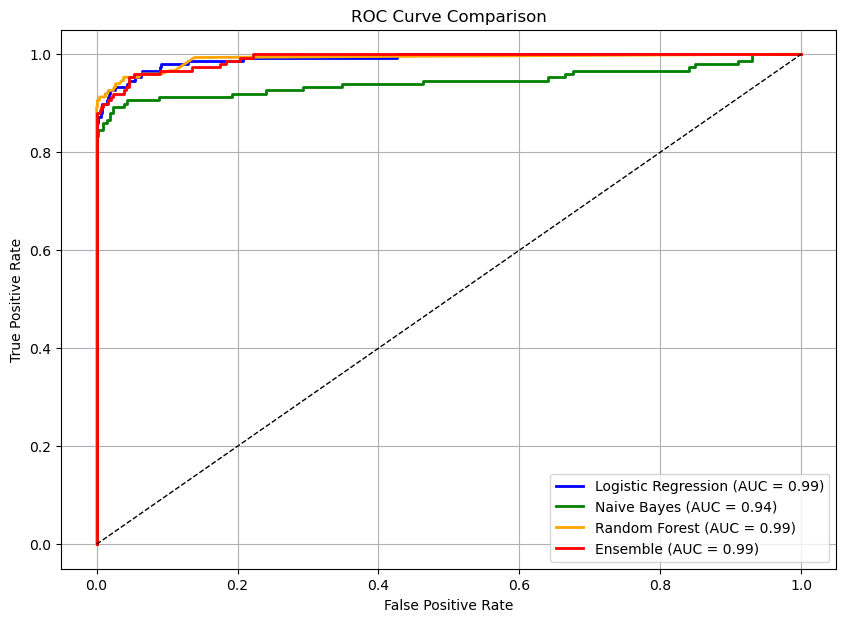

In [35]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

# Instantiate base models
log_clf = LogisticRegression()
nb_clf = MultinomialNB()
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Create ensemble model using soft voting
ensemble_clf = VotingClassifier(
    estimators=[
        ('lr', log_clf),
        ('nb', nb_clf),
        ('rf', rf_clf)
    ],
    voting='soft'
)

# Fit the ensemble model
ensemble_clf.fit(X_train, y_train)

# Predict and evaluate
y_pred_ensemble = ensemble_clf.predict(X_test)
y_proba_ensemble = ensemble_clf.predict_proba(X_test)[:, 1]

# Evaluation report
from sklearn.metrics import classification_report, confusion_matrix

print("Classification Report - Ensemble Model:")
print(classification_report(y_test, y_pred_ensemble))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_ensemble))
print("AUC Score:", roc_auc_score(y_test, y_proba_ensemble))

# Plot ROC Curves for all models
plt.figure(figsize=(10, 7))

# Helper to add ROC curve
def plot_roc(model, name, color):
    y_score = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')

plot_roc(log_clf.fit(X_train, y_train), "Logistic Regression", 'blue')
plot_roc(nb_clf.fit(X_train, y_train), "Naive Bayes", 'green')
plot_roc(rf_clf.fit(X_train, y_train), "Random Forest", 'orange')
plot_roc(ensemble_clf, "Ensemble", 'red')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
